# Results

This notebook provides a structured approach to:
1. Easily enable/disable different feature groups
2. Test multiple feature combinations systematically
3. Compare performance across different configurations


In [2]:
# ===== IMPORTS =====
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations, product

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# ===== CONFIGURATION =====
# Define random seed
seed = 42

# Individual Feature Configuration - Set to True/False to enable/disable each feature
FEATURE_CONFIG = {
    # === ATTRIBUTE FEATURES ===
    'attribute_i': True,              # Individual attribute value for node i
    'attribute_j': True,              # Individual attribute value for node j
    'attribute_equality': True,       # Attribute equality indicator
    
    # === BASIC NODE FEATURES ===
    'degree_i': True,                 # Degree of node i
    'degree_j': True,                 # Degree of node j
    'clustering_i': True,             # Clustering coefficient of node i
    'clustering_j': True,             # Clustering coefficient of node j
    'pagerank_i': True,               # PageRank of node i
    'pagerank_j': True,               # PageRank of node j
    
    # === NEIGHBORHOOD FEATURES ===
    'common_neighbors': True,         # Number of common neighbors
    'jaccard_coefficient': True,      # Jaccard coefficient
    'adamic_adar': True,              # Adamic-Adar index
    'resource_allocation': True,       # Resource Allocation index
    'preferential_attachment': True,   # Preferential Attachment
    'salton_index': True,             # Salton index
    'sorensen_index': True,           # Sorensen index
    'two_hop_neighbors': True,        # 2-hop neighbors count
    
    # === DERIVED FEATURES ===
    'degree_sum': True,               # Sum of degrees
    'degree_diff': True,              # Absolute difference of degrees
    'degree_product': True,            # Product of degrees
    'degree_ratio': True,             # Ratio of degrees (min/max)
    'clustering_avg': True,           # Average clustering coefficient
    'pagerank_avg': True,             # Average PageRank
    
    # === COMMUNITY FEATURES ===
    'same_community': True,           # Same community indicator
    'community_size_i': True,         # Community size of node i
    'community_size_j': True,         # Community size of node j
    'community_size_diff': True,      # Absolute difference in community sizes
    'community_size_ratio': True,     # Ratio of community sizes
}

# Model Configuration
MODEL_CONFIG = {
    'n_estimators': 100,
    'max_depth': 3,
    'min_samples_split': 10,
    'min_samples_leaf': 3,
    'random_state': seed,
    'n_jobs': -1
}

# Cross-validation Configuration
CV_CONFIG = {
    'n_splits': 5,
    'shuffle': True,
    'random_state': seed
}

# Community Configuration
COMMUNITY_CONFIG = {
    'resolution': 1.0,  # Can be changed for different resolutions
    'test_resolutions': np.arange(0.5, 2.0, 0.1).tolist()  # For testing multiple resolutions
}

print("✓ Configuration loaded")


✓ Configuration loaded


In [3]:
# ===== DATA LOADING =====
def load_data():
    """Load graph and attributes data"""
    # Load graph
    path = "./../assignment2_files_2025/edges_train.edgelist"
    G = nx.read_edgelist(path, delimiter=',', nodetype=int, create_using=nx.Graph())
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Load attributes
    pathattributes = "./../assignment2_files_2025/attributes.csv"
    attributes_df = pd.read_csv(pathattributes)
    node_id_col = attributes_df.columns[0]
    attribute_cols = [col for col in attributes_df.columns if col != node_id_col]
    
    # Encode categorical to numerical
    for col in attribute_cols:
        if attributes_df[col].dtype == 'object':
            le = LabelEncoder()
            attributes_df[col] = le.fit_transform(attributes_df[col].astype(str))
            print(f"   ✓ Encoded '{col}': {list(le.classes_)}")
    
    attributes_dict = attributes_df.set_index(node_id_col).to_dict('index')
    
    return G, attributes_dict, attribute_cols

# Load data
G, attributes_dict, attribute_cols = load_data()
print("✓ Data loaded successfully")


Graph loaded with 1500 nodes and 6600 edges
   ✓ Encoded 'attribute': ['d', 'f', 'l', 'm', 'x', 'y']
✓ Data loaded successfully


In [7]:
# ===== FEATURE ENGINEERING =====
def get_features(G, i, j, feature_config=FEATURE_CONFIG, precomputed_metrics=None):
    """
    Features voor node pair (i, j) based on configuration
    Args:
        G: NetworkX graph
        i, j: Node pair
        feature_config: Feature configuration dictionary
        precomputed_metrics: Dictionary with precomputed metrics (pa, pagerank, clustering, community_dict, comm_sizes)
    Returns: (feature_array, feature_names)
    """
    features = []
    feature_names = []
    
    # Get attribute values
    attrs_i = attributes_dict.get(i, {})
    attrs_j = attributes_dict.get(j, {})
    
    # --- Attribute features ---
    for col in attribute_cols:
        val_i = attrs_i.get(col, 0)
        val_j = attrs_j.get(col, 0)
        
        if feature_config['attribute_i']:
            features.append(val_i)
            feature_names.append(f"{col}_i")
        
        if feature_config['attribute_j']:
            features.append(val_j)
            feature_names.append(f"{col}_j")
        
        if feature_config['attribute_equality']:
            features.append(int(val_i == val_j))
            feature_names.append(f"{col}_eq")
    
    # --- Basic node features ---
    deg_i = G.degree(i)
    deg_j = G.degree(j)
    
    # Use precomputed metrics if available, otherwise compute on-the-fly
    if precomputed_metrics:
        cc_i = precomputed_metrics['clustering'].get(i, 0)
        cc_j = precomputed_metrics['clustering'].get(j, 0)
        pr_i = precomputed_metrics['pagerank'].get(i, 0)
        pr_j = precomputed_metrics['pagerank'].get(j, 0)
    else:
        # Fallback: compute on-the-fly (not recommended for performance)
        cc_i = nx.clustering(G, i)
        cc_j = nx.clustering(G, j)
        pr_i = nx.pagerank(G)[i] if i in nx.pagerank(G) else 0
        pr_j = nx.pagerank(G)[j] if j in nx.pagerank(G) else 0
    
    if feature_config['degree_i']:
        features.append(deg_i)
        feature_names.append('deg_i')
    
    if feature_config['degree_j']:
        features.append(deg_j)
        feature_names.append('deg_j')
    
    if feature_config['clustering_i']:
        features.append(cc_i)
        feature_names.append('cc_i')
    
    if feature_config['clustering_j']:
        features.append(cc_j)
        feature_names.append('cc_j')
    
    if feature_config['pagerank_i']:
        features.append(pr_i)
        feature_names.append('pr_i')
    
    if feature_config['pagerank_j']:
        features.append(pr_j)
        feature_names.append('pr_j')
    
    # --- Neighborhood features ---
    common = list(nx.common_neighbors(G, i, j))
    cn_ij = len(common)
    
    if feature_config['common_neighbors']:
        features.append(cn_ij)
        feature_names.append('cn_ij')
    
    if feature_config['jaccard_coefficient']:
        jc_ij = next(nx.jaccard_coefficient(G, [(i,j)]))[2]
        features.append(jc_ij)
        feature_names.append('jc_ij')
    
    if feature_config['adamic_adar']:
        aa_ij = sum(1.0 / np.log(G.degree(z)) for z in common if G.degree(z) > 1)
        features.append(aa_ij)
        feature_names.append('aa_ij')
    
    if feature_config['resource_allocation']:
        ra_ij = sum(1.0 / G.degree(z) for z in common if G.degree(z) > 0)
        features.append(ra_ij)
        feature_names.append('ra_ij')
    
    if feature_config['preferential_attachment']:
        if precomputed_metrics and 'pa' in precomputed_metrics:
            pa_ij = precomputed_metrics['pa'][i, j]
        else:
            # Fallback: compute on-the-fly (very expensive!)
            pa_ij = next(nx.preferential_attachment(G, [(i, j)]))[2]
        features.append(pa_ij)
        feature_names.append('pa_ij')
    
    if feature_config['salton_index']:
        salton = cn_ij / np.sqrt(deg_i * deg_j) if (deg_i * deg_j) > 0 else 0
        features.append(salton)
        feature_names.append('salton')
    
    if feature_config['sorensen_index']:
        sorensen = (2 * cn_ij) / (deg_i + deg_j) if (deg_i + deg_j) > 0 else 0
        features.append(sorensen)
        feature_names.append('sorensen')
    
    if feature_config['two_hop_neighbors']:
        # 2 hop neighbors
        dist2_i = set(nx.single_source_shortest_path_length(G, i, cutoff=2))
        dist2_j = set(nx.single_source_shortest_path_length(G, j, cutoff=2))
        
        # remove the nodes themselves and their direct neighbors
        dist2_i -= {i} | set(G.neighbors(i))
        dist2_j -= {j} | set(G.neighbors(j))
        
        # intersection of these "exactly distance-2" neighborhoods
        dist2_count = len(dist2_i & dist2_j)
        features.append(dist2_count)
        feature_names.append('dist2_count')
    
    # --- Derived features ---
    if feature_config['degree_sum']:
        deg_sum = deg_i + deg_j
        features.append(deg_sum)
        feature_names.append('deg_sum')
    
    if feature_config['degree_diff']:
        deg_diff = abs(deg_i - deg_j)
        features.append(deg_diff)
        feature_names.append('deg_diff')
    
    if feature_config['degree_product']:
        deg_product = deg_i * deg_j
        features.append(deg_product)
        feature_names.append('deg_product')
    
    if feature_config['degree_ratio']:
        deg_ratio = min(deg_i, deg_j) / max(deg_i, deg_j) if max(deg_i, deg_j) > 0 else 0
        features.append(deg_ratio)
        feature_names.append('deg_ratio')
    
    if feature_config['clustering_avg']:
        cc_avg = (cc_i + cc_j) / 2
        features.append(cc_avg)
        feature_names.append('cc_avg')
    
    if feature_config['pagerank_avg']:
        pr_avg = (pr_i + pr_j) / 2
        features.append(pr_avg)
        feature_names.append('pr_avg')
    
    # --- Community features ---
    if precomputed_metrics and 'community_dict' in precomputed_metrics:
        comm_i = precomputed_metrics['community_dict'].get(i, -1)
        comm_j = precomputed_metrics['community_dict'].get(j, -1)
        comm_sizes = precomputed_metrics['comm_sizes']
    else:
        # Fallback: compute communities on-the-fly (expensive!)
        communities = list(nx.algorithms.community.greedy_modularity_communities(G))
        community_dict = {n: cid for cid, nodes in enumerate(communities) for n in nodes}
        comm_sizes = {cid: len(nodes) for cid, nodes in enumerate(communities)}
        comm_i = community_dict.get(i, -1)
        comm_j = community_dict.get(j, -1)
    
    if feature_config['same_community']:
        same_comm = int(comm_i == comm_j)
        features.append(same_comm)
        feature_names.append('same_comm')
    
    if feature_config['community_size_i']:
        size_i = comm_sizes.get(comm_i, 0)
        features.append(size_i)
        feature_names.append('size_i')
    
    if feature_config['community_size_j']:
        size_j = comm_sizes.get(comm_j, 0)
        features.append(size_j)
        feature_names.append('size_j')
    
    if feature_config['community_size_diff']:
        size_i = comm_sizes.get(comm_i, 0)
        size_j = comm_sizes.get(comm_j, 0)
        abs_size_diff = abs(size_i - size_j)
        features.append(abs_size_diff)
        feature_names.append('abs_size_diff')
    
    if feature_config['community_size_ratio']:
        size_i = comm_sizes.get(comm_i, 0)
        size_j = comm_sizes.get(comm_j, 0)
        if size_i + size_j > 0:
            rel_size_ratio = size_i / (size_j + 1e-6)
        else:
            rel_size_ratio = 0
        features.append(rel_size_ratio)
        feature_names.append('rel_size_ratio')
    
    return np.array(features, dtype=float), feature_names

def precompute_metrics(G_train, community_resolution=1.0):
    """
    Pre-compute all expensive graph metrics using ONLY training graph
    Args:
        G_train: NetworkX training graph (only training edges)
        community_resolution: Resolution parameter for community detection
    Returns:
        Dictionary with precomputed metrics
    """
    N = G_train.number_of_nodes()
    
    # Preferential Attachment
    pa = np.zeros((N, N))
    for u, v, p in nx.preferential_attachment(G_train, [(i, j) for i in range(N) for j in range(N)]):
        pa[u, v] = p
    
    # PageRank
    pagerank = nx.pagerank(G_train)
    
    # Clustering        
    clustering = nx.clustering(G_train)
    
    # Communities
    communities = list(nx.algorithms.community.greedy_modularity_communities(G_train, resolution=community_resolution))
    community_dict = {n: cid for cid, nodes in enumerate(communities) for n in nodes}
    comm_sizes = {cid: len(nodes) for cid, nodes in enumerate(communities)}
    
    return {
        'pa': pa,
        'pagerank': pagerank,
        'clustering': clustering,
        'community_dict': community_dict,
        'comm_sizes': comm_sizes
    }

print("✓ Feature engineering function defined")
print("✓ Precomputed metrics helper function defined")


✓ Feature engineering function defined
✓ Precomputed metrics helper function defined


In [21]:
# ===== SINGLE CONFIGURATION TESTING =====
def test_single_configuration(feature_config, model_config=MODEL_CONFIG, cv_config=CV_CONFIG, community_resolution=1.25):
    """Test a single feature configuration"""
    print(f"\n=== Testing Configuration ===")
    print(f"Enabled features: {[k for k, v in feature_config.items() if v]}")
    
    # Initialize results
    auc_scores = []
    acc_scores = []
    
    # K-fold cross validation
    edges = np.array(list(G.edges()))
    kf = KFold(n_splits=cv_config['n_splits'], shuffle=cv_config['shuffle'], random_state=cv_config['random_state'])
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(edges), 1):
        print(f"\n--- Fold {fold} ---")
        
        # Split edges
        train_edges = edges[train_idx]
        val_edges = edges[val_idx]
        
        # Build training graph
        G_train = nx.Graph()
        G_train.add_nodes_from(G.nodes())
        G_train.add_edges_from(train_edges)
        
        # Pre-compute metrics using helper function
        precomputed_metrics = precompute_metrics(G_train, community_resolution)
        
        # Build training data
        pos_train = train_edges
        rng = np.random.default_rng(seed)
        non_edges = np.array(list(nx.non_edges(G_train)))
        neg_train = non_edges[rng.choice(len(non_edges), size=len(pos_train), replace=False)]
        
        X_train_features = []
        for (u, v) in np.vstack([pos_train, neg_train]):
            feat, _ = get_features(G_train, u, v, feature_config, precomputed_metrics)
            X_train_features.append(feat)
        
        y_train = [1]*len(pos_train) + [0]*len(neg_train)
    
        # Build validation data
        pos_val = val_edges
        rng2 = np.random.default_rng(seed+1)
        non_edges = np.array(list(nx.non_edges(G_train)))
        neg_val = non_edges[rng2.choice(len(non_edges), size=len(pos_val), replace=False)]
        
        X_val_features = []
        for (u, v) in np.vstack([pos_val, neg_val]):
            feat, _ = get_features(G_train, u, v, feature_config, precomputed_metrics)
            X_val_features.append(feat)
        
        y_val = [1]*len(pos_val) + [0]*len(neg_val)
    
        # Train model
        clf = RandomForestClassifier(**model_config)
        clf.fit(X_train_features, y_train)
        
        # Evaluate
        y_pred_proba = clf.predict_proba(X_val_features)[:,1]
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)
        
        y_pred_val = clf.predict(X_val_features)
        val_acc = accuracy_score(y_val, y_pred_val)
        acc_scores.append(val_acc)
        
        print(f"Fold {fold} AUC: {auc:.4f}, Accuracy: {val_acc:.4f}")
    
    # Calculate final results
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    mean_acc = np.mean(acc_scores)
    std_acc = np.std(acc_scores)
    
    print(f"\n=== Results ===")
    print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    
    return {
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'mean_acc': mean_acc,
        'std_acc': std_acc,
        'auc_scores': auc_scores,
        'acc_scores': acc_scores,
        'clf': clf,
        'features': X_train_features
    }

print("✓ Single configuration testing function defined")


✓ Single configuration testing function defined


In [9]:
# ===== INDIVIDUAL FEATURE TESTING =====
def test_individual_features(max_features=10):
    """Test individual features to identify the most important ones"""
    results = []
    
    # Test each individual feature
    print("\n=== Testing Individual Features ===")
    for feature_name in FEATURE_CONFIG.keys():
        config = {key: False for key in FEATURE_CONFIG.keys()}
        config[feature_name] = True
        
        print(f"\nTesting {feature_name}...")
        result = test_single_configuration(config)
        result['config_name'] = feature_name
        result['features'] = [feature_name]
        results.append(result)
    
    # Sort by AUC to find best individual features
    results.sort(key=lambda x: x['mean_auc'], reverse=True)
    
    # Test combinations of top features
    print("\n=== Testing Top Feature Combinations ===")
    top_features = [r['config_name'] for r in results[:max_features]]
    
    # Test all combinations of 2 top features
    for combo in combinations(top_features, 2):
        config = {key: False for key in FEATURE_CONFIG.keys()}
        config_name = f"{combo[0]} + {combo[1]}"
        
        for feature in combo:
            config[feature] = True
        
        print(f"\nTesting {config_name}...")
        result = test_single_configuration(config)
        result['config_name'] = config_name
        result['features'] = list(combo)
        results.append(result)
    
    # Test all features
    print("\n=== Testing All Features ===")
    config = {key: True for key in FEATURE_CONFIG.keys()}
    result = test_single_configuration(config)
    result['config_name'] = 'all_features'
    result['features'] = list(FEATURE_CONFIG.keys())
    results.append(result)
    
    return result


✓ Individual feature testing functions defined


In [10]:
# ===== RESULTS ANALYSIS =====
def analyze_results(results):
    """Analyze and visualize results from feature testing"""
    # Create results DataFrame
    df_results = pd.DataFrame([
        {
            'config_name': r['config_name'],
            'mean_auc': r['mean_auc'],
            'std_auc': r['std_auc'],
            'mean_acc': r['mean_acc'],
            'std_acc': r['std_acc'],
            'num_features': len(r['features'])
        }
        for r in results
    ])
    
    # Sort by AUC
    df_results = df_results.sort_values('mean_auc', ascending=False)
    
    print("\n=== RESULTS SUMMARY ===")
    print(df_results.to_string(index=False))
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # AUC plot
    x_pos = range(len(df_results))
    ax1.bar(x_pos, df_results['mean_auc'], yerr=df_results['std_auc'], 
            capsize=5, alpha=0.7, color='skyblue')
    ax1.set_xlabel('Configuration')
    ax1.set_ylabel('AUC Score')
    ax1.set_title('AUC Scores by Feature Configuration')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df_results['config_name'], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.bar(x_pos, df_results['mean_acc'], yerr=df_results['std_acc'], 
            capsize=5, alpha=0.7, color='lightcoral')
    ax2.set_xlabel('Configuration')
    ax2.set_ylabel('Accuracy Score')
    ax2.set_title('Accuracy Scores by Feature Configuration')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(df_results['config_name'], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Feature count vs performance
    plt.figure(figsize=(10, 6))
    plt.scatter(df_results['num_features'], df_results['mean_auc'], 
                s=100, alpha=0.7, c='blue', label='AUC')
    plt.scatter(df_results['num_features'], df_results['mean_acc'], 
                s=100, alpha=0.7, c='red', label='Accuracy')
    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Performance vs Number of Features')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return df_results

print("✓ Results analysis function defined")


✓ Results analysis function defined


## Usage Examples

### 1. Get Individual Feature importance
Run this to test the current feature configuration and find the feature importances and correlations


In [23]:
# Test current configuration
current_result = test_single_configuration(FEATURE_CONFIG)
print(f"\nCurrent configuration performance:")
print(f"AUC: {current_result['mean_auc']:.4f} ± {current_result['std_auc']:.4f}")
print(f"Accuracy: {current_result['mean_acc']:.4f} ± {current_result['std_acc']:.4f}")

clf = current_result['clf']

importances = clf.feature_importances_


=== Testing Configuration ===
Enabled features: ['attribute_i', 'attribute_j', 'attribute_equality', 'degree_i', 'degree_j', 'clustering_i', 'clustering_j', 'pagerank_i', 'pagerank_j', 'common_neighbors', 'jaccard_coefficient', 'adamic_adar', 'resource_allocation', 'preferential_attachment', 'salton_index', 'sorensen_index', 'two_hop_neighbors', 'degree_sum', 'degree_diff', 'degree_product', 'degree_ratio', 'clustering_avg', 'pagerank_avg', 'same_community', 'community_size_i', 'community_size_j', 'community_size_diff', 'community_size_ratio']

--- Fold 1 ---
Fold 1 AUC: 0.9236, Accuracy: 0.8807

--- Fold 2 ---
Fold 2 AUC: 0.9277, Accuracy: 0.8769

--- Fold 3 ---
Fold 3 AUC: 0.9287, Accuracy: 0.8814

--- Fold 4 ---
Fold 4 AUC: 0.9271, Accuracy: 0.8773

--- Fold 5 ---
Fold 5 AUC: 0.9294, Accuracy: 0.8769

=== Results ===
Mean AUC: 0.9273 ± 0.0020
Mean Accuracy: 0.8786 ± 0.0020

Current configuration performance:
AUC: 0.9273 ± 0.0020
Accuracy: 0.8786 ± 0.0020


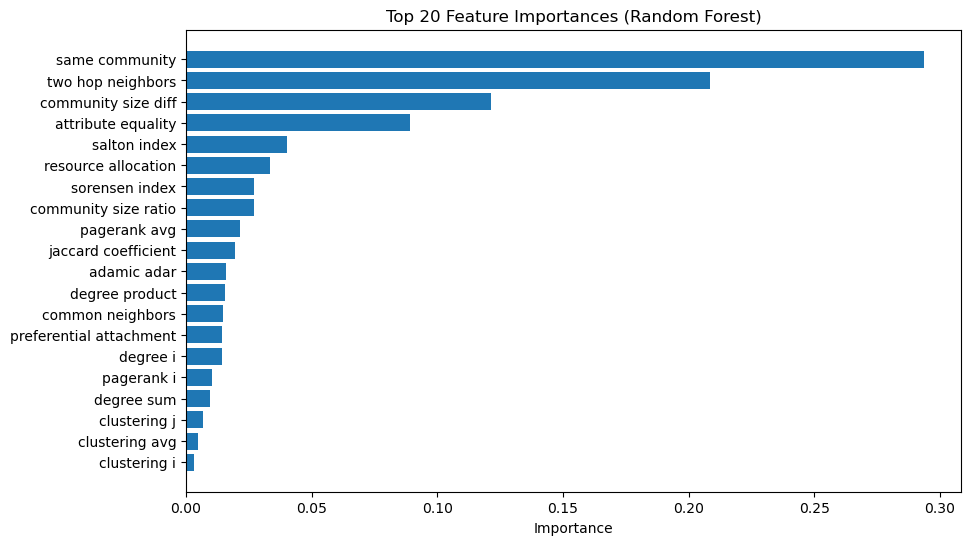

<Figure size 640x480 with 0 Axes>

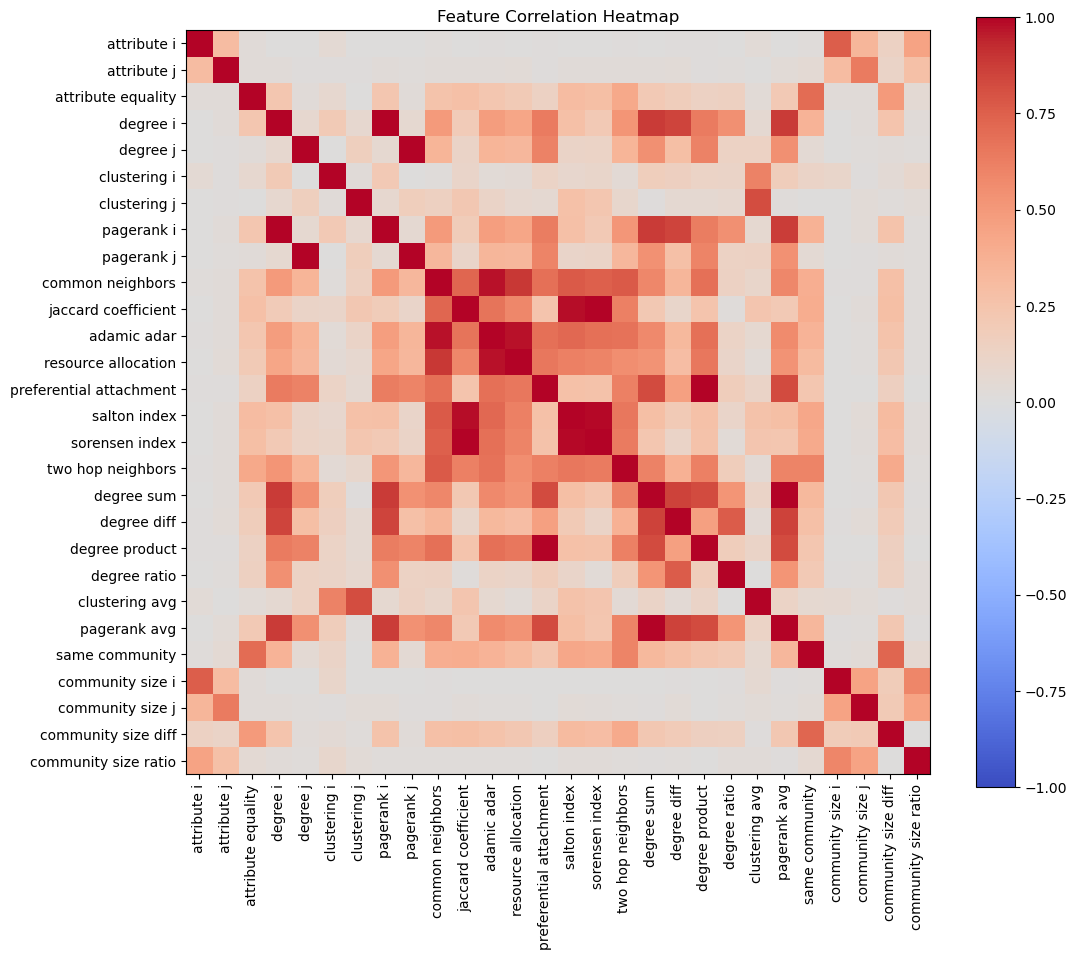

<Figure size 640x480 with 0 Axes>

In [29]:
# Get feature names
feature_names = list(FEATURE_CONFIG.keys())

# Rank features
labels = [feature_name.replace("_", " ") for feature_name in feature_names]
feat_df = pd.DataFrame({
    'Feature': labels,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_df['Feature'][:20][::-1], feat_df['Importance'][:20][::-1])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()
plt.savefig("importances.jpg")

# X = np.array([get_features(G, u, v) for (u,v) in np.vstack([pos_train, neg_train])])
X = current_result['features']
corr = abs(pd.DataFrame(X, columns=feature_names).corr())
plt.figure(figsize=(12,10))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(len(feature_names)), labels=labels, rotation=90)
plt.yticks(ticks=np.arange(len(feature_names)), labels=labels)
plt.colorbar()
plt.title("Feature Correlation Heatmap")
plt.show()
plt.savefig("correlations.jpg")


### 2. Test Individual Features
Run this to test each feature individually and find the most important ones.



=== Testing Individual Features ===

Testing attribute_i...

=== Testing Configuration ===
Enabled features: ['attribute_i']

--- Fold 1 ---
Fold 1 AUC: 0.6203, Accuracy: 0.5913

--- Fold 2 ---
Fold 2 AUC: 0.6093, Accuracy: 0.5879

--- Fold 3 ---
Fold 3 AUC: 0.6310, Accuracy: 0.6011

--- Fold 4 ---
Fold 4 AUC: 0.6321, Accuracy: 0.5973

--- Fold 5 ---
Fold 5 AUC: 0.6389, Accuracy: 0.6110

=== Results ===
Mean AUC: 0.6263 ± 0.0104
Mean Accuracy: 0.5977 ± 0.0081

Testing attribute_j...

=== Testing Configuration ===
Enabled features: ['attribute_j']

--- Fold 1 ---
Fold 1 AUC: 0.6498, Accuracy: 0.6167

--- Fold 2 ---
Fold 2 AUC: 0.6496, Accuracy: 0.6212

--- Fold 3 ---
Fold 3 AUC: 0.6386, Accuracy: 0.6148

--- Fold 4 ---
Fold 4 AUC: 0.6429, Accuracy: 0.6136

--- Fold 5 ---
Fold 5 AUC: 0.6508, Accuracy: 0.6174

=== Results ===
Mean AUC: 0.6463 ± 0.0048
Mean Accuracy: 0.6167 ± 0.0026

Testing attribute_equality...

=== Testing Configuration ===
Enabled features: ['attribute_equality']

---

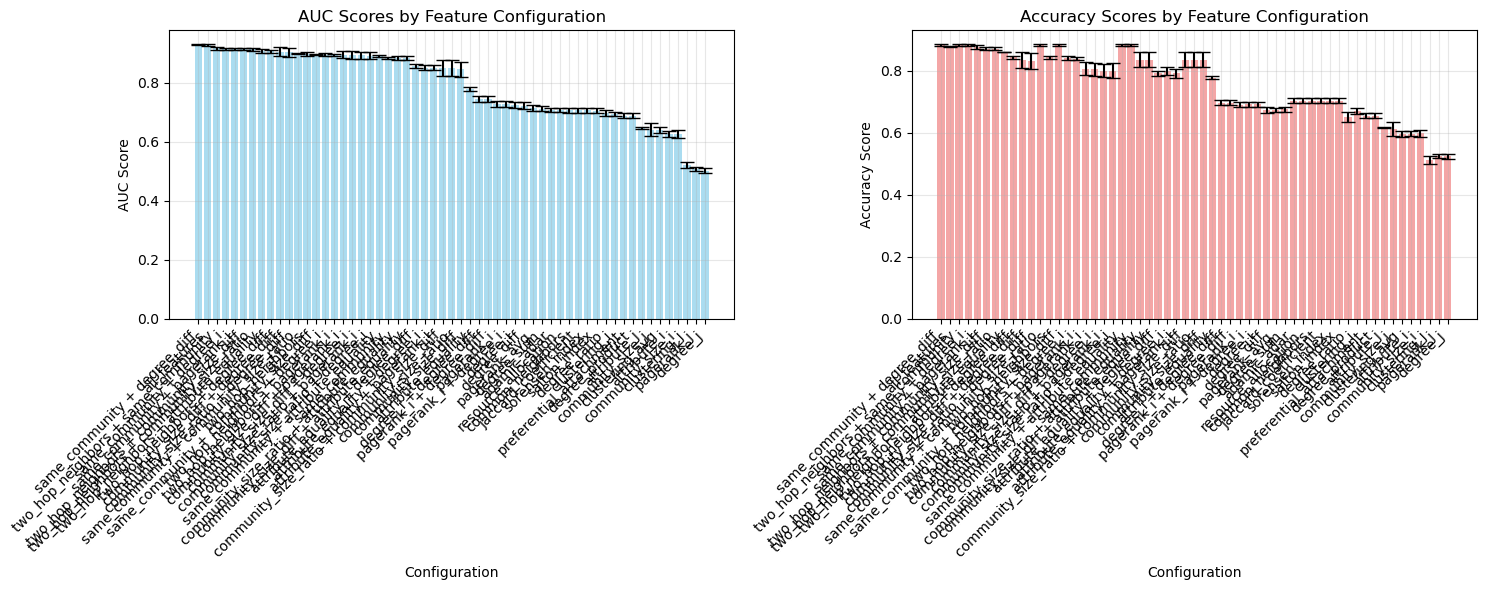

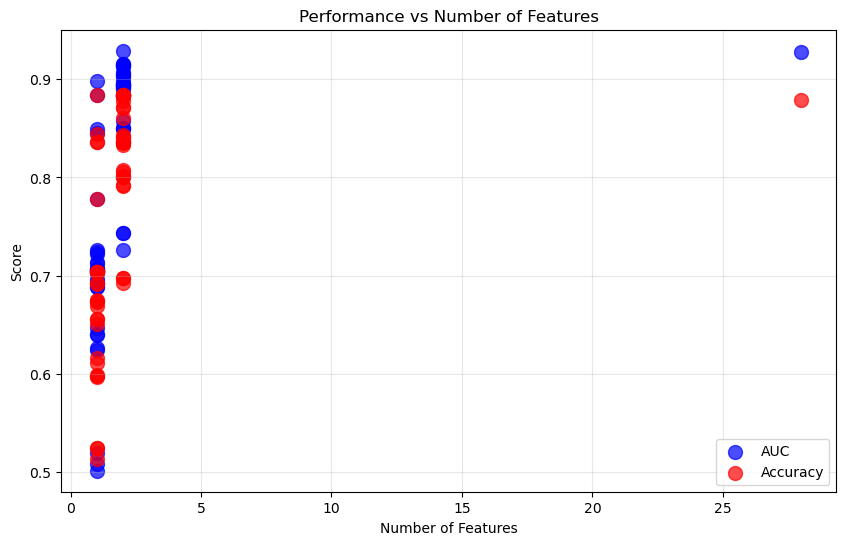

In [32]:
# Test individual features to find the most important ones
results = test_individual_features(max_features=8)
df_results = analyze_results(results)


### 3. Test Feature Groups
Run this to test logical feature groups and their combinations.


In [ ]:
# Test feature groups and their combinations
group_results = test_feature_groups()
df_group_results = analyze_results(group_results)


### 4. Custom Individual Feature Configuration
Modify the configuration below to test specific individual features.


In [33]:
# Custom configuration - modify individual features as needed
custom_config = {
    # === ATTRIBUTE FEATURES ===
    'attribute_i': False,              # Individual attribute value for node i
    'attribute_j': False,               # Individual attribute value for node j
    'attribute_equality': True,       # Disable attribute equality
    
    # === BASIC NODE FEATURES ===
    'degree_i': False,                  # Degree of node i
    'degree_j': False,                  # Degree of node j
    'clustering_i': False,             # Disable clustering for node i
    'clustering_j': False,             # Disable clustering for node j
    'pagerank_i': False,                # PageRank of node i
    'pagerank_j': False,                # PageRank of node j
    
    # === NEIGHBORHOOD FEATURES ===
    'common_neighbors': False,          # Number of common neighbors
    'jaccard_coefficient': False,       # Jaccard coefficient
    'adamic_adar': False,              # Disable Adamic-Adar
    'resource_allocation': False,        # Resource Allocation index
    # 'preferential_attachment': False,   # Preferential Attachment
    'salton_index': False,             # Disable Salton index
    'sorensen_index': False,             # Sorensen index
    'two_hop_neighbors': True,        # Disable 2-hop neighbors
    
    # === DERIVED FEATURES ===
    'degree_sum': False,                # Sum of degrees
    'degree_diff': True,               # Absolute difference of degrees
    'degree_product': False,             # Product of degrees
    'degree_ratio': False,              # Ratio of degrees
    'clustering_avg': False,           # Disable average clustering
    'pagerank_avg': False,             # Disable average PageRank
    
    # === COMMUNITY FEATURES ===
    'same_community': True,             # Same community indicator
    'community_size_i': False,           # Community size of node i
    'community_size_j': False,           # Community size of node j
    'community_size_diff': False,        # Absolute difference in community sizes
    'community_size_ratio': False,     # Disable community size ratio
}

# Test custom configuration
custom_result = test_single_configuration(custom_config)
print(f"\nCustom configuration performance:")
print(f"AUC: {custom_result['mean_auc']:.4f} ± {custom_result['std_auc']:.4f}")
print(f"Accuracy: {custom_result['mean_acc']:.4f} ± {custom_result['std_acc']:.4f}")



=== Testing Configuration ===
Enabled features: ['attribute_equality', 'two_hop_neighbors', 'degree_diff', 'same_community']

--- Fold 1 ---
Fold 1 AUC: 0.9255, Accuracy: 0.8826

--- Fold 2 ---
Fold 2 AUC: 0.9350, Accuracy: 0.8803

--- Fold 3 ---
Fold 3 AUC: 0.9337, Accuracy: 0.8852

--- Fold 4 ---
Fold 4 AUC: 0.9336, Accuracy: 0.8837

--- Fold 5 ---
Fold 5 AUC: 0.9319, Accuracy: 0.8871

=== Results ===
Mean AUC: 0.9319 ± 0.0034
Mean Accuracy: 0.8838 ± 0.0023

Custom configuration performance:
AUC: 0.9319 ± 0.0034
Accuracy: 0.8838 ± 0.0023


In [45]:
# Custom configuration - modify individual features as needed
custom_config = {
    # === ATTRIBUTE FEATURES ===
    'attribute_i': True,              # Individual attribute value for node i
    'attribute_j': True,               # Individual attribute value for node j
    'attribute_equality': False,       # Disable attribute equality
    
    # === BASIC NODE FEATURES ===
    'degree_i': False,                  # Degree of node i
    'degree_j': False,                  # Degree of node j
    'clustering_i': False,             # Disable clustering for node i
    'clustering_j': False,             # Disable clustering for node j
    'pagerank_i': False,                # PageRank of node i
    'pagerank_j': False,                # PageRank of node j
    
    # === NEIGHBORHOOD FEATURES ===
    'common_neighbors': False,          # Number of common neighbors
    'jaccard_coefficient': False,       # Jaccard coefficient
    'adamic_adar': False,              # Disable Adamic-Adar
    'resource_allocation': False,        # Resource Allocation index
    'preferential_attachment': False,   # Preferential Attachment
    'salton_index': False,             # Disable Salton index
    'sorensen_index': False,             # Sorensen index
    'two_hop_neighbors': False,        # Disable 2-hop neighbors
    
    # === DERIVED FEATURES ===
    'degree_sum': False,                # Sum of degrees
    'degree_diff': False,               # Absolute difference of degrees
    'degree_product': False,             # Product of degrees
    'degree_ratio': False,              # Ratio of degrees
    'clustering_avg': False,           # Disable average clustering
    'pagerank_avg': False,             # Disable average PageRank
    
    # === COMMUNITY FEATURES ===
    'same_community': True,             # Same community indicator
    'community_size_i': False,           # Community size of node i
    'community_size_j': False,           # Community size of node j
    'community_size_diff': False,        # Absolute difference in community sizes
    'community_size_ratio': False,     # Disable community size ratio
}

# Test custom configuration
custom_result = test_single_configuration(custom_config)
print(f"\nCustom configuration performance:")
print(f"AUC: {custom_result['mean_auc']:.4f} ± {custom_result['std_auc']:.4f}")
print(f"Accuracy: {custom_result['mean_acc']:.4f} ± {custom_result['std_acc']:.4f}")



=== Testing Configuration ===
Enabled features: ['same_community']

--- Fold 1 ---
Fold 1 AUC: 0.8826, Accuracy: 0.8826

--- Fold 2 ---
Fold 2 AUC: 0.8795, Accuracy: 0.8795

--- Fold 3 ---
Fold 3 AUC: 0.8848, Accuracy: 0.8848

--- Fold 4 ---
Fold 4 AUC: 0.8837, Accuracy: 0.8837

--- Fold 5 ---
Fold 5 AUC: 0.8871, Accuracy: 0.8871

=== Results ===
Mean AUC: 0.8836 ± 0.0025
Mean Accuracy: 0.8836 ± 0.0025

Custom configuration performance:
AUC: 0.8836 ± 0.0025
Accuracy: 0.8836 ± 0.0025


### 5. Generate Predictions for Best Configuration
Use this to generate predictions for Kaggle submission with the best individual feature configuration.


In [ ]:
# Generate predictions for best configuration
def generate_predictions(best_config, best_model_config=MODEL_CONFIG, output_filename='predictions_best_config.csv'):
    """
    Generate predictions using the best individual feature configuration
    NOTE: This function trains on ALL available training data (no cross-validation)
    """
    print(f"\n=== Generating Predictions with Best Configuration ===")
    
    # Load test data
    inpTest = pd.read_csv('./../assignment2_files_2025/solutionInput.csv', sep=',', index_col='ID')
    
    # Use ALL training edges for final model (this is the correct approach for Kaggle)
    edges = np.array(list(G.edges()))
    pos_edges = edges
    rng = np.random.default_rng(seed)
    non_edges = np.array(list(nx.non_edges(G)))
    neg_edges = non_edges[rng.choice(len(non_edges), size=len(pos_edges), replace=False)]
    
    # Pre-compute metrics on the FULL training graph (this is correct for final submission)
    precomputed_metrics = precompute_metrics(G, COMMUNITY_CONFIG['resolution'])
    
    # Generate features for training data
    X_train = []
    for (u, v) in np.vstack([pos_edges, neg_edges]):
        feat, _ = get_features(G, u, v, best_config, precomputed_metrics)
        X_train.append(feat)
    
    y_train = [1]*len(pos_edges) + [0]*len(neg_edges)
    
    # Train model
    clf = RandomForestClassifier(best_model_config)
    clf.fit(X_train, y_train)
    
    # Generate features for test data (using same precomputed metrics)
    test_features = []
    for _, row in inpTest.iterrows():
        feat, _ = get_features(G, int(row.iloc[0]), int(row.iloc[1]), best_config, precomputed_metrics)
        test_features.append(feat)
    
    # Generate predictions
    predictions = clf.predict(test_features)
    
    # Save predictions
    sub = pd.DataFrame({'ID': inpTest.index, 'prediction': predictions})
    sub.to_csv(output_filename, index=False)
    
    print(f"✅ Predictions saved to {output_filename}")
    return clf, test_features